导包

In [1]:
# Import libraries for data handling and model training
#from datasets import Dataset  # For handling datasets compatible with Hugging Face
import pandas as pd  # For data manipulation
import numpy as np  # For numerical operations
import re
import matplotlib.pyplot as plt
import seaborn as sns

查看

In [2]:
# 加载 CSV 文件
data = pd.read_csv('/kaggle/input/steam-reviews/output.csv')



In [3]:
# 删除不需要
data = data.rename(columns={'is_positive':'label', 'content':'text'})
data = data[['text', 'label']]
data['label'] = data['label'].map({'Positive': 1, 'Negative': 0})
data.head(3)


,text,label
0,At least its a counter strike -1/100,0
1,Uh... So far my playthrough has not been great...,0
2,Better mechanics than cs2,0


In [5]:
df =data
df['label'].value_counts()

label
1    102660
0     98491
Name: count, dtype: int64

In [6]:
df = df.dropna()

In [7]:


def clean_text(t):
    t = re.sub(r'<.*?>', '', t)  # remove HTML tags
    t = re.sub(r'[^\w\s]', '', t)  # remove special characters
    t = re.sub(r'\s+', ' ', t)  # remove extra whitespaces
    t = t.strip()  # remove leading and trailing spaces
    return t.lower()  # convert to lowercase

df['text_clean'] = df['text'].apply(clean_text)

print('done')

done


<ipython-input-7-93790ce3bbc1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_clean'] = df['text'].apply(clean_text)


<ipython-input-8-d4dbf028850e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review_length'] = df['text_clean'].apply(len)


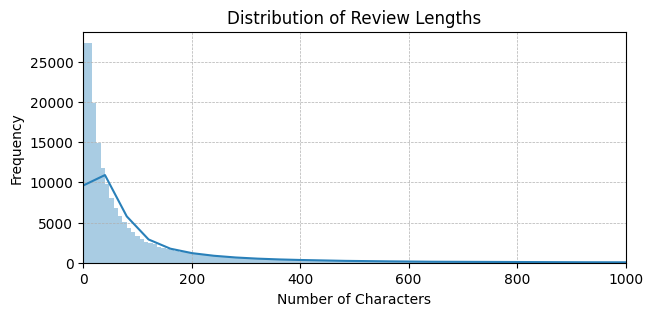

In [8]:


# Hide Warning Messages
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Count Review Length
df['review_length'] = df['text_clean'].apply(len)

# Distribution of Review Lengths
plt.figure(figsize=(7, 3))
sns.histplot(df['review_length'], bins=1000, kde=True, color='#2980b9', edgecolor=None, alpha=0.4)
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)


plt.xlim(0, 1000)
plt.show()

In [9]:
#print(df[df['review_length'] == 50].sample(20))

In [10]:
df = df[df['review_length'] >= 10]


In [11]:
df['label'].value_counts()

label
0    83563
1    81112
Name: count, dtype: int64

In [12]:
from sklearn.model_selection import train_test_split

# Split Data fot Training and Temporary
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['text_clean'],  df['label'], test_size=0.95, random_state=42
    )

# Split Data for Validation and Test
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.6, random_state=42
    )

print(f"Training Set: {len(train_texts)} samples")
print(f"Validation Set: {len(val_texts)} samples")
print(f"Test Set: {len(test_texts)} samples")

Training Set: 8233 samples
Validation Set: 62576 samples
Test Set: 93866 samples


In [13]:

# Hugging Face Transformers library
#from transformers import AutoTokenizer, TrainingArguments, Trainer
#from transformers import AutoModelForSequenceClassification, DistilBertConfig
#from transformers import EarlyStoppingCallback, TrainerCallback, TrainerState, TrainerControl

# Evaluation metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from transformers import BertTokenizer

# Initialize BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define Function for Tokenization
#将数据集中的文本数据转换为模型可以接受的格式。这里我们会使用 tokenizer 来将文本转换为 token IDs，并进行适当的 padding 和 truncation。
def tokenize_reviews(reviews, max_length=128):
    return tokenizer(
        reviews.tolist(),
        padding='max_length',  # pad sequences to the same length
        truncation=True,       # truncate sequences longer than max_length
        max_length=max_length, # maximum sequence length
        return_tensors="pt"    # return PyTorch tensors
    )

# Tokenizing the Training, Validation, and Test Sets
train_encodings = tokenize_reviews(train_texts)
val_encodings = tokenize_reviews(val_texts)
test_encodings = tokenize_reviews(test_texts)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [14]:
import torch
from torch.utils.data import Dataset

# Custom Dataset class
#定义了一个自定义的 Dataset 类，用于将预处理后的输入和标签数据封装起来，方便与 PyTorch 的 DataLoader 进行配合使用。
#在自然语言处理（NLP）任务中，通常会将文本数据转换为模型能够理解的格式（如 token IDs），然后通过这个 Dataset 类将其与标签一起提供给模型进行训练或评估
class steam(Dataset):
    #
    def __init__(self, encodings, labels):
        self.encodings = encodings        #包含分词后的文本数据，通常是一个字典，包含了如 input_ids, labels,attention_mask 等字段。
        self.labels = labels
"""
attention_mask 的作用
在模型内部： Transformer 模型中的自注意力机制（self-attention）会计算输入的所有 token 之间的关系。
如果不使用 attention_mask，模型会将填充部分也视为有效输入，从而浪费计算资源并影响模型性能。
attention_mask 通过指示哪些 token 是有效的，哪些是填充的，帮助模型 忽略填充部分 的影响，确保模型只关注实际的输入。
在训练过程中： 在训练时，attention_mask 会与输入一起传递到模型中，以便模型在计算注意力时排除掉填充部分，不会让填充 token 对预测结果产生影响。

"""

    
    def __len__(self):
        return len(self.labels)

    #这个方法允许你根据索引 idx 访问数据集中的单个样本。
    #对于每个样本，它会将对应的 input_ids、attention_mask 和 labels（标签）封装成一个字典返回。
    #所有的输入（如 token IDs）都被转换为 PyTorch 的 torch.tensor 类型，以便后续的训练和推理。

#item['labels'] = torch.tensor(self.labels[idx])：这是将标签转换为张量并添加到返回字典中的步骤，确保标签也以适当的形式提供给模型。
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Prepare Dataset Objects封装成 PyTorch 可以处理的数据集。
train_dataset = steam(train_encodings, train_labels.tolist())
val_dataset = steam(val_encodings, val_labels.tolist())
test_dataset = steam(test_encodings, test_labels.tolist())

In [15]:
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader

# Load Pre-trained BERT Model with Classification Head
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define DataLoader for Batching指定批次大小和是否打乱数据

"""
梯度估计的精度：
大批次：在每次训练步骤中，使用更多的样本来计算梯度,更好地利用 GPU，因此会产生更精确的梯度估计。通常，这可能会导致训练更加稳定，但可能会减缓训练速度。
小批次：使用较少的样本进行梯度计算，因此每次计算出的梯度会更为噪声，训练过程可能会更加不稳定，但有时也可能会帮助避免过拟合，并使得模型能更好地泛化。
"""
def create_data_loader(dataset, batch_size=32):
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Apply Dataloader in Datasets创建 DataLoader 对象
train_loader = create_data_loader(train_dataset)
val_loader = create_data_loader(val_dataset)
test_loader = create_data_loader(test_dataset)

# Define Optimizer# 设置优化器
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
#AdamW 是你使用的优化器，它是一个基于 Adam 的优化器，带有权重衰减（Weight Decay）机制，通常用于训练大规模的深度学习模型。
#lr=1e-5 设置了学习率，即每次参数更新时，步长为该值。##


# Define the loss function
loss_fn = torch.nn.CrossEntropyLoss()
"""
CrossEntropyLoss 交叉熵损失解释
torch.nn.CrossEntropyLoss() 是 PyTorch 中用于计算分类问题损失的函数，通常用于 多类分类 和 二分类（如果类别数为 2）。
它结合了 softmax 和 负对数似然损失（Negative Log Likelihood Loss, NLLLoss）：

Softmax：首先将模型的输出转换为概率分布（即每个类别的概率值）。
负对数似然损失：然后基于预测的概率与实际标签之间的差异计算损失。
"""

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# Early Stopping class
class EarlyStopping:
    def __init__(self, patience=3, delta=0):
        """
        patience: 当验证损失没有改善时，允许等待的epoch数
        delta: 容忍的最小变化，只有当验证损失改善超过这个阈值时才会更新
        """
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.best_epoch = 0
        self.counter = 0

    def __call__(self, val_loss, model, epoch):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.best_epoch = epoch
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Early stopping at epoch {epoch}")
                return True  # 触发早停
        return False

# 创建早停对象
early_stopping = EarlyStopping(patience=3, delta=0.02)


In [17]:
# 保存模型
def save_model(model, optimizer, epoch, val_loss, filepath="best_model.pth"):
    # 保存模型和优化器的状态字典
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_loss': val_loss,
    }, filepath)
    print(f"Model saved at epoch {epoch} with validation loss: {val_loss:.4f}")


In [18]:
# Training & Validation Loop with Early Stopping
def train_model_with_metrics(model, train_loader, val_loader, optimizer, loss_fn, epochs=5, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    train_losses = []
    val_losses = []
    val_accuracies = []

    best_val_loss = float('inf')
    patience_counter = 0  # 用来监控验证集损失是否连续没有改善

    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for batch in train_loader:
             #将输入数据和标签转移到设备上
            inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)

            # 清零梯度
            #在每次反向传播（backpropagation）之前，你需要清零上一次计算的梯度。
            #这是因为 PyTorch 默认是会累计梯度的，若不清零，梯度会在每个批次中不断累加，从而导致梯度计算错误。
            
            optimizer.zero_grad()
            
             # 前向传播
            #它通过将输入数据传递到模型中，计算每一层的输出并最终得出模型的预测结果。在这一步，你将数据传递给模型并得到预测值
            
            outputs = model(**inputs)

               # 计算损失

            loss = loss_fn(outputs.logits, labels)
              # 反向传播和优化
            loss.backward()
            #根据当前的梯度信息更新所有参数（权重和偏置）通过 梯度下降 或其他优化算法（如 Adam、SGD 等）
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
                labels = batch['labels'].to(device)

                
                outputs = model(**inputs)
                loss = loss_fn(outputs.logits, labels)
                val_loss += loss.item()

                preds = torch.argmax(outputs.logits, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
   
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        
        # Print out training & validation results
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


         # 检查验证集损失是否改进
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter += 0
            # 保存最佳模型
            save_model(model, optimizer, epoch, avg_val_loss)
        else:
            patience_counter += 1

        
        # Early stopping check
        if early_stopping(avg_val_loss, model, epoch):
            break  # If early stopping is triggered, exit training loop


    return train_losses, val_losses, val_accuracies

In [19]:
# Train Model and Collect Metrics
train_losses, val_losses, val_accuracies = train_model_with_metrics(model, train_loader, val_loader, optimizer, loss_fn)

Epoch 1/3
Train Loss: 0.4824, Validation Loss: 0.3739, Validation Accuracy: 0.8305
Model saved at epoch 0 with validation loss: 0.3739
Epoch 2/3
Train Loss: 0.3214, Validation Loss: 0.3568, Validation Accuracy: 0.8448
Model saved at epoch 1 with validation loss: 0.3568
Epoch 3/3
Train Loss: 0.2494, Validation Loss: 0.3587, Validation Accuracy: 0.8501


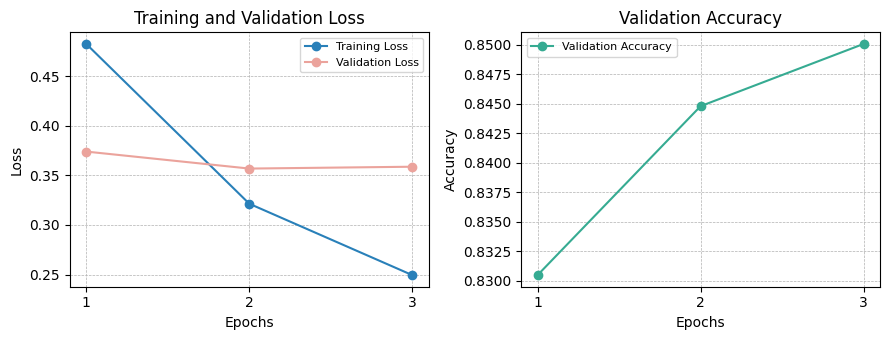

In [20]:
# Plot Training Results
metrics = [
    (train_losses, val_losses, 'Loss', 'Training and Validation Loss', ['Training Loss', 'Validation Loss']),
    (val_accuracies, None, 'Accuracy', 'Validation Accuracy', ['Validation Accuracy'])
]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))

# Plot each metric using a loop
for i, (metric1, metric2, ylabel, title, labels) in enumerate(metrics):
    axes[i].plot(range(1, len(metric1) + 1), metric1, label=labels[0], color='#2980b9' if i == 0 else '#36ab92', marker='o')
    if metric2 is not None:
        axes[i].plot(range(1, len(metric2) + 1), metric2, label=labels[1], color='#eba39c', marker='o')
    axes[i].set_title(title)
    axes[i].set_xlabel('Epochs')
    axes[i].set_ylabel(ylabel)
    axes[i].set_xticks(range(1, len(metric1) + 1))
    axes[i].grid(True, which='both', linestyle='--', linewidth=0.5)
    axes[i].legend(fontsize=8)

plt.tight_layout()
plt.show()

In [21]:
# Evaluate on Test Set
def evaluate_on_test_set(model, test_loader, loss_fn, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_loader:
            inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            test_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = correct / total
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

In [22]:
# 加载模型
def load_model(model, optimizer, filepath="best_model.pth"):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    val_loss = checkpoint['val_loss']
    print(f"Model loaded from epoch {epoch} with validation loss: {val_loss:.4f}")
    return model, optimizer, epoch, val_loss
    
# 恢复模型
model, optimizer, epoch, val_loss = load_model(model, optimizer, filepath="best_model.pth")


Model loaded from epoch 1 with validation loss: 0.3568


In [23]:
###evaluate_on_test_set(model, test_loader, loss_fn)